# Measuring the Qubit ac-Stark Shift

### Physics Background

Let's consider a qubit with frequency $\omega_q$ strongly coupled to a resonator with frequency $\omega_r$ with $\omega_q<\omega_r$; the qubit-resonator coupling strength is $g$ and the detuning is $\Delta=\omega_q-\omega_r$. In the dispersive limit, the system can be described using the following Hamiltonian: 

$H_{JC(disp)}/\hbar=\omega_r (a^\dagger a+\frac{1}{2}) + \frac{1}{2} (\omega_q + \frac{g^2}{\Delta} + \frac{2g^2}{\Delta} a^\dagger a) \sigma_z$

where $a$ and $a^\dagger$ are the raising and lowering operators of the resonator photons, and $\sigma_z$ is the Pauli-Z operator acting on the qubit. In this frame, the qubit frequency 

$\tilde{\omega}_q=\omega_q + \frac{g^2}{\Delta} + \frac{2g^2}{\Delta} \bar{n}$ 

experiences a constant Lamb shift of $g^2/\Delta$ induced by the vacuum fluctuations in the resonator, and an ac-Stark shift of $(2g^2/\Delta) \bar{n}$ where $\bar{n}=\langle a^\dagger a \rangle$ is the average number of photons present in the resonator. For more details checkout this <a href="https://arxiv.org/abs/cond-mat/0408367">paper</a>. In this tutorial, we investigate the ac-Stark shift of the qubit caused by the photon population in the resonator using Qiskit Pulse.

### 0. Getting started

We'll first set up our basic dependencies so we're ready to go.

In [1]:
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.circuit import Gate
from qiskit import schedule as build_schedule
# Loading your IBM Q account(s)
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

We then extract the default backend configuration and settings for the selected chip.

In [2]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()

We specify a control channel from the backend configuration for use in the experiment.

In [3]:
qind = 0
cmap = []
for i, j in backend_config.coupling_map:
    if i == qind:
        cmap.append([i, j])
pair = cmap[0]
con_chan = backend_config.control(pair)[0]

Next, we define some helper functions that we will use for fitting and interpreting our data.

In [4]:
from scipy.optimize import leastsq,minimize, curve_fit

# samples need to be multiples of 16 to accommodate the hardware limitations
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

# lorentzian function
def lorentzian(f, f0, k, a, offs):
    return a*k/(2*np.pi)/((k/2)**2+(f-f0)**2)+offs

#fit_lorentzian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the lorentzian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_lorentzian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(lorentzian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# Gaussian function
def gaussian(f, f0, sigma, a, offs):
    return a*np.exp(-(f-f0)**2/(2*sigma**2))+offs

#fit_gaussian takes two arrays that contain the frequencies and experimental output values of each frequency respectively. 
#returns the gaussian parameters that best fits this output of the experiment.
#popt are the fit parameters and pcov is the covariance matrix for the fit
def fit_gaussian(freqs,values):
    p0=[freqs[np.argmax(values)],(freqs[-1]-freqs[0])/2,max(values),0]
    bounds=([freqs[0],0,0,-np.inf],[freqs[-1],freqs[-1]-freqs[0],np.inf,np.inf])
    popt,pcov=curve_fit(gaussian, freqs, values, p0=p0, bounds=bounds)
    return popt,pcov

# normalize the data points to fall in the range of [0,1]
def normalize(a):
    a= a-min(a)
    return a/max(a)

### 1.  ac-Stark Shifting the qubit
In order to ac-Stark shift the qubit we need to populate the resonator with photons using an on-resonance drive. For a drive amplitude $\epsilon$, and a resonator decay rate of $\kappa$, the number of photons in the resonator $\bar{n}=\langle a^\dagger a \rangle = \frac{\epsilon^2}{\Delta^2 +(\kappa/2)^2}$. As a reminder $\tilde{\omega}_q=\omega_q + \frac{g^2}{\Delta} + \delta \omega_q$ where the shift in frequency due to ac-Stark shift is $\delta \omega_q = \frac{2g^2}{\Delta} \bar{n}$. Since $\Delta=\omega_q-\omega_r<0$ the qubit frequency gets smaller as we increase the of photons in the resonator.

In [5]:
from qiskit import pulse            # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit=0   # qubit used in our experiment

qubit_drive_sigma = 0.1 * us        #the width of the qubit spectroscopy drive
stark_tone_drive_sigma=10 * ns      #This is Gaussian sigma of rising and falling edge
drive_duration=8*qubit_drive_sigma  #the stark drive duration

start=4.960 * GHz  # qubit spectroscopy start frequency
stop=4.980 * GHz   # qubit spectroscopy stop frequency
freqs = np.linspace(start, stop, 41)

In [6]:
# pulse sequence for the experiment at different amplitudes
amplitude = Parameter('amplitude')
drive_freq = Parameter('drive_freq')
control_freq = Parameter('control_freq')
with pulse.build(backend=backend, name='ac Stark Shift Experimet') as stark_pulse:
    duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration))
    drive_qubit_sigma = pulse.seconds_to_samples(qubit_drive_sigma)
    drive_stark_tone_sigma = pulse.seconds_to_samples(stark_tone_drive_sigma)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(drive_freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=duration,
                              amp = 0.05,
                              sigma=drive_qubit_sigma,
                              name='qubit tone'), drive_chan)
    pulse.set_frequency(control_freq, con_chan)
    pulse.play(pulse.GaussianSquare(duration = duration,
                                    amp = amplitude,
                                    sigma = drive_stark_tone_sigma,
                                    risefall_sigma_ratio = 2,
                                    name = 'stark tone'), con_chan)

In [7]:
stark_spect_gate = Gate("stark", 1, [amplitude, drive_freq, control_freq])

qc_stark = QuantumCircuit(1, 1)

qc_stark.append(stark_spect_gate, [0])
qc_stark.measure(0, 0)
qc_stark.add_calibration(stark_spect_gate, (0,), stark_pulse)

In [8]:
stark_tone_amplitude = np.linspace(0, 0.2, 11) #change to amplitude

Here, we send our pulse sequence to the hardware.

In [9]:
from qiskit.tools.monitor import job_monitor

num_shots = 4*1024

stark_tone_results=[]
for amp in stark_tone_amplitude:
    qc_stark_circs = [qc_stark.assign_parameters({amplitude: amp , drive_freq: f, control_freq: f - 100 * MHz}, inplace=False) for f in freqs]
    job = backend.run(qc_stark_circs, 
                      meas_level=1, 
                      meas_return='avg', 
                      shots=num_shots)
    job_monitor(job)
    stark_tone_results.append(job.result(timeout=120))

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


And then we access the measurement data.

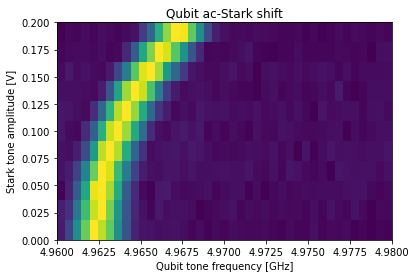

In [10]:
import matplotlib.pyplot as plt

skip_idx=0

stark_tone_values = []
for result in stark_tone_results:
    result_values=[]
    for i in range(len(result.results)):
        result_values.append(result.get_memory(i)[qubit])

    stark_tone_values.append(normalize(result_values))
    
plot_extent=[freqs[0]/GHz, freqs[-1]/GHz, stark_tone_amplitude[skip_idx], stark_tone_amplitude[-1]]
plt.imshow(np.abs(stark_tone_values[skip_idx:]), aspect='auto', origin='lower', cmap='viridis',
          extent=plot_extent)

plt.xlabel('Qubit tone frequency [GHz]')
plt.ylabel('Stark tone amplitude [V]')
plt.title('Qubit ac-Stark shift')
plt.show()

### 2.  Qubit frequency shift and linewidth broadening
Using the Jaynes-Cummings model we expect a qubit frequency shift of $\delta \omega_q = \frac{2g^2}{\Delta} \bar{n}$. The qubit frequency experiences fluctuations due the photon shot-noise which leads to qubit linewidth broadening and a dephasing rate of $\Gamma_\phi=\frac{4 \chi^2}{\kappa} \bar{n}$.

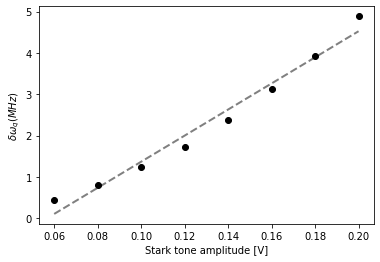

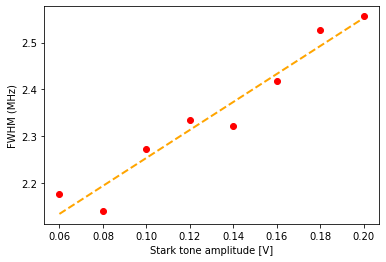

In [11]:
show_individual_traces=False
skip_idx=3  # number of points to skip

center=[]
fwhm=[]
for i in range(len(stark_tone_values)):
    popt,pcov=fit_gaussian(freqs,np.abs(np.real(stark_tone_values[i])))
    center.append(popt[0])
    fwhm.append(2.355*popt[1])
    if show_individual_traces:
        plt.plot(freqs/1e3, np.real(stark_tone_values[i]))
        plt.plot(freqs/1e3, gaussian(freqs,*popt), '--')
if show_individual_traces: plt.show()

center_fit=np.polyfit(stark_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0]),1)
plt.plot(stark_tone_amplitude[skip_idx:], np.poly1d(center_fit/1e6)(stark_tone_amplitude[skip_idx:]), '--', lw=2, color='grey')
plt.plot(stark_tone_amplitude[skip_idx:], (center[skip_idx:]-center[0])/1e6, 'o', color='black')
plt.xlabel(r'Stark tone amplitude [V]')
plt.ylabel(r'$\delta \omega_q (MHz)$')
plt.show()

fwhm_fit=np.polyfit(stark_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:]),1)
plt.plot(stark_tone_amplitude[skip_idx:], np.poly1d(fwhm_fit/1e6)(stark_tone_amplitude[skip_idx:]), '--', lw=2, color='orange')
plt.plot(stark_tone_amplitude[skip_idx:], np.array(fwhm[skip_idx:])/1e6, 'o', color='red')
plt.xlabel(r'Stark tone amplitude [V]')
plt.ylabel(r'FWHM (MHz)')
plt.show()

In this chapter, we discuss the ac-Stark shift that the qubit experiences due to the presence of photons in the resonator. We use Qiskit Pulse to measure the qubit frequency shift and linewidth broadening.

In [12]:
import qiskit.tools.jupyter
%qiskit_version_table